### Explore EMIT datasets 
Here we took a look at EMIT data by using the S3 bucket to visualize soil and vegetation cover in Australia. 
We also chose to look at EMIT data to investigate the high Car and mARI values in Australia. Here, we look an EMIT scene from the peak vegetation season and visualize spectra from areas that have 'pure red soil' and mixed vegetation and soil pixels to explain how some vegetation indexes may be difficult to apply globaly in areas with sparse vegetation and large influence from the soil background. 

In [ ]:
# install required libraries 
!pip install folium
!pip install folium matplotlib mapclassify
!pip install spectral
!pip install GDAL

In [3]:
# Import required libraries
import os
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import math

import xarray as xr
import numpy as np

from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

import hvplot.xarray
import holoviews as hv
from emit_tools import emit_xarray, ortho_xr
import requests
import s3fs

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
# functions
# Define Function 
def get_temp_creds(provider):
    return requests.get(s3_cred_endpoint[provider]).json()
    temp_creds_req = get_temp_creds('lpdaac')

# Function to adjust gamma across all bands - adjust brightness
def gamma_adjust(rgb_ds, bright=0.2, white_background=False):
    array = rgb_ds.reflectance.data
    gamma = math.log(bright)/math.log(np.nanmean(array)) # Create exponent for gamma scaling - can be adjusted by changing 0.2 
    scaled = np.power(array,gamma).clip(0,1) # Apply scaling and clip to 0-1 range
    if white_background == True:
        scaled = np.nan_to_num(scaled, nan = 1) # Assign NA's to 1 so they appear white in plots
    rgb_ds.reflectance.data = scaled
    return rgb_ds
# Function to build spectral plot of clicked location to show on hover stream plot
def click_spectra(data):
    coordinates = []
    if data is None or not any(len(d) for d in data.values()):
        coordinates.append(clicked_points[0][0], clicked_points[1][0])
    else:
        coordinates = [c for c in zip(data['x'], data['y'])]
    
    plots = []
    for i, coords in enumerate(coordinates):
        x, y = coords
        data = ds.sel(longitude=x, latitude=y, method="nearest")
        plots.append(
            data.hvplot.line(
                y="reflectance",
                x="wavelengths",
                color=color_cycle,
                label=f"{i}"
            )
        )
        points_stream.data["id"][i] = i
    return hv.Overlay(plots)

def hover_spectra(x,y):
    return ds.sel(longitude=x,latitude=y,method='nearest').hvplot.line(y='reflectance',x='wavelengths',
                                                                           color='black', frame_width=400)

In [5]:
# set up credentials 
credentials = earthaccess.get_s3_credentials(provider="LP_CLOUD") 

s3_cred_endpoint = {
    'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials',
    'gesdisc': 'https://data.gesdisc.earthdata.nasa.gov/s3credentials',
    'lpdaac':'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials',
    'ornldaac': 'https://data.ornldaac.earthdata.nasa.gov/s3credentials',
    'ghrcdaac': 'https://data.ghrc.earthdata.nasa.gov/s3credentials'
}

temp_creds_req = get_temp_creds('lpdaac')

fs_s3 = s3fs.S3FileSystem(anon=False, 
                          key=temp_creds_req['accessKeyId'], 
                          secret=temp_creds_req['secretAccessKey'], 
                          token=temp_creds_req['sessionToken'])

Here, we load a preselected EMIT image from western Australia that has some pure red soil patches, as well as, some that are mixed with vegetation 

In [6]:
s3_url = 's3://lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20241128T004323_2433216_008/EMIT_L2A_RFL_001_20241128T004323_2433216_008.nc'

# open s3 url
fp = fs_s3.open(s3_url, mode='rb')
# Open and Orthorectify
ds = emit_xarray(fp, ortho=True)
ds.reflectance.data[ds.reflectance.data == -9999] = np.nan # Mask out fill_values

<figure>
    <img src="emit_example_spectra.png" alt="" width="800">
    <figcaption style="font-style: italic; margin-bottom: 40px;"> Emit Example Spectra</figcaption>
</figure> 

### Minerals 

Here, we will show the mineral map for hematite abundance.

In [11]:
s3_minerals = 's3://lp-prod-protected/EMITL3ASA.001/EMIT_L3_ASA_001/EMIT_L3_ASA_001.nc'
# open s3 url
fp_min = fs_s3.open(s3_minerals, mode='rb')
ds_min = xr.open_mfdataset(fp_min)

In [15]:
# More memory-efficient approach: find bounding box indices directly
bbox = (113.338953078, -43.6345972634, 153.569469029, -10.6681857235)
min_lon, min_lat, max_lon, max_lat = bbox

# Load just the coordinate arrays (much smaller than the full dataset)
lat_data = ds_min['latitude'].compute()
lon_data = ds_min['longitude'].compute()

# Find indices that fall within bounding box
lat_mask = (lat_data >= min_lat) & (lat_data <= max_lat)
lon_mask = (lon_data >= min_lon) & (lon_data <= max_lon)
geographic_mask = lat_mask & lon_mask

# Find the bounding box of valid indices
valid_indices = geographic_mask.values.nonzero()
if len(valid_indices[0]) > 0:
    min_lat_idx = valid_indices[0].min()
    max_lat_idx = valid_indices[0].max()
    min_lon_idx = valid_indices[1].min()
    max_lon_idx = valid_indices[1].max()
    
    # Slice using integer indices (much faster)
    australia = ds_min.isel(
        lat=slice(min_lat_idx, max_lat_idx + 1),
        lon=slice(min_lon_idx, max_lon_idx + 1)
    )
    
    print(f"Original shape: lat={ds_min.dims['lat']}, lon={ds_min.dims['lon']}")
    print(f"Cropped shape: lat={australia.dims['lat']}, lon={australia.dims['lon']}")
    print(f"Bounding indices: lat[{min_lat_idx}:{max_lat_idx+1}], lon[{min_lon_idx}:{max_lon_idx+1}]")
else:
    print("No data found in the specified bounding box!")

Original shape: lat=220, lon=690
Cropped shape: lat=66, lon=81
Bounding indices: lat[132:198], lon[557:638]


In [16]:
#australia
hem = australia['Hematite']

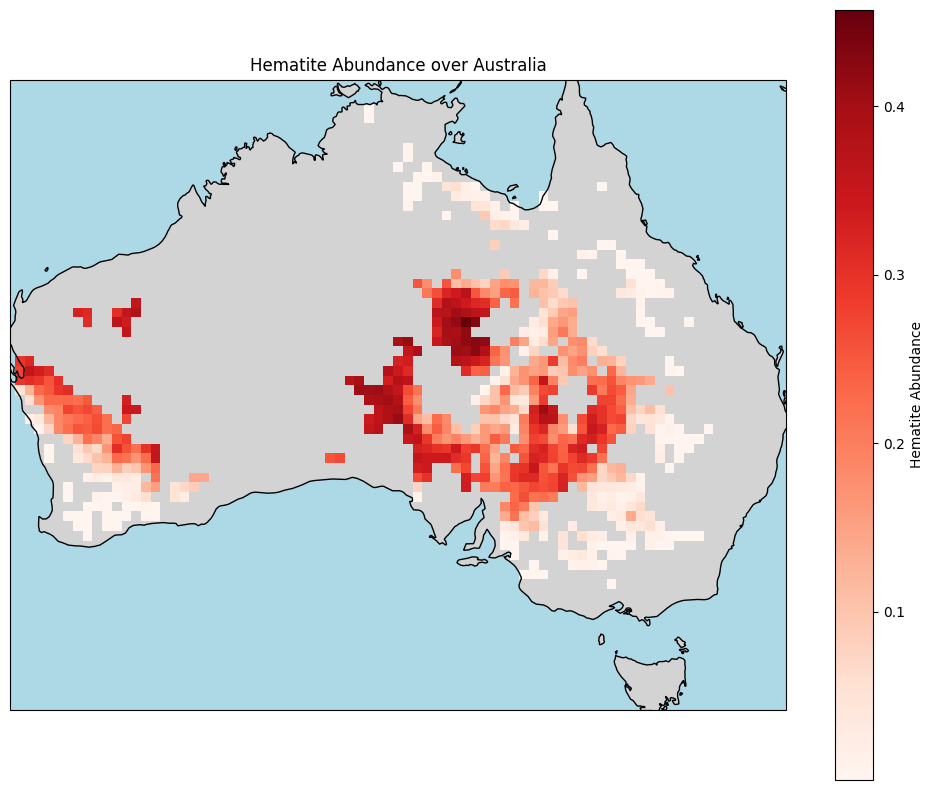

In [22]:
# Create a single plot with a PlateCarree projection (good for lat/lon data)
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the Hematite data
hem_plot = ax.pcolormesh(
    australia['longitude'], 
    australia['latitude'], 
    hem, 
    cmap='Reds', 
    shading='auto',
    transform=ccrs.PlateCarree()  # Specify the coordinate system of the data
)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.set_extent([
    australia['longitude'].min(), 
    australia['longitude'].max(), 
    australia['latitude'].min(), 
    australia['latitude'].max()
], crs=ccrs.PlateCarree())

# Add labels and title
ax.set_title('Hematite Abundance over Australia')
plt.colorbar(hem_plot, ax=ax, orientation='vertical', label='Hematite Abundance')

plt.tight_layout()
plt.show()